# Imports

In [1]:
import os, torch, random
import SimpleITK
import numpy as np
import matplotlib.pyplot as plt 
from torchvision import transforms
from torch.utils.data import DataLoader
import re
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

In [2]:
SEED = 2024

def seed_everything(seed):
    random.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)

seed_everything(SEED)

## GPU

In [3]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


# Dataset

In [4]:
data_transforms = {
    'train': transforms.Compose([
        # Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] 
        # to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
        transforms.ToTensor(), 
        # transforms.RandomResizedCrop(224),
        # transforms.RandomHorizontalFlip(),
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(), # PIL Image or numpy.ndarray (H x W x C)
        # transforms.Resize(256),
        # transforms.CenterCrop(224)
    ]),
}

In [5]:
from OASIS_2D.dataset import OASIS_Dataset

train_dataset = OASIS_Dataset(train=True, seed=SEED)
test_dataset = OASIS_Dataset(train=False, seed=SEED)

batch_size = 8
train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

Total 77, disease 37, healthy 40.             Unique patients 42.
Total 23, disease 13, healthy 10.             Unique patients 11.


# Model

In [6]:
from torchvision import models

# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
model = models.resnet50(weights='DEFAULT')
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model.fc = torch.nn.Linear(num_ftrs, 2)

model = model.to(device)

# Train

In [7]:
from OASIS_2D.oasis import Experiment

result_dir = os.path.join('OASIS_2D', 'scratch', model._get_name())
exp = Experiment(result_dir=result_dir, device=device)

train_history = exp.train(
    model, train_dataloader=train_dataloader, 
    val_dataloader=test_dataloader,
    epochs=25, learning_rate=1e-3
)

Epoch 1/25
----------
Train loss: 6.3170 Acc: 0.5974
Val loss: 1.6137 Acc: 0.7391
Validation loss decreased (inf --> 1.613694).  Saving model ...

Epoch 2/25
----------
Train loss: 3.8952 Acc: 0.8312
Val loss: 13.4306 Acc: 0.7826
EarlyStopping counter: 1 out of 10

Epoch 3/25
----------
Train loss: 1.1214 Acc: 0.9481
Val loss: 25.3754 Acc: 0.4348
EarlyStopping counter: 2 out of 10

Epoch 4/25
----------
Train loss: 1.9221 Acc: 0.9351
Val loss: 1.5016 Acc: 0.7826
Validation loss decreased (1.613694 --> 1.501584).  Saving model ...

Epoch 5/25
----------
Train loss: 0.7966 Acc: 0.9610
Val loss: 0.8800 Acc: 0.9130
Validation loss decreased (1.501584 --> 0.880039).  Saving model ...

Epoch 6/25
----------
Train loss: 4.4828 Acc: 0.8442
Val loss: 3.7451 Acc: 0.6087
EarlyStopping counter: 1 out of 10

Epoch 7/25
----------
Train loss: 2.1993 Acc: 0.9091
Val loss: 0.9399 Acc: 0.8261
EarlyStopping counter: 2 out of 10

Epoch 8/25
----------
Train loss: 0.4782 Acc: 1.0000
Val loss: 23.1360 Acc:

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

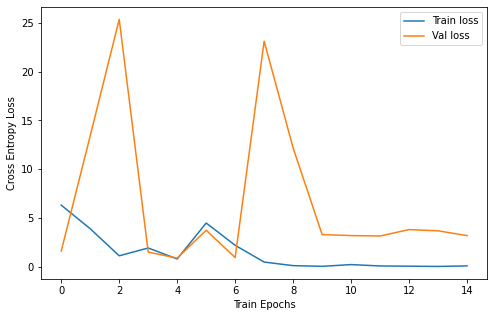

In [17]:
plt.figure(figsize=(8, 5))
plt.plot(train_history['epoch'], train_history['train_loss'], label='Train loss')
plt.plot(train_history['epoch'], train_history['val_loss'], label='Val loss')
plt.xlabel('Train Epochs')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

# Test

In [8]:
train_result = exp.test(model, train_dataloader)
test_result = exp.test(model, test_dataloader)

Loss: 1.3661, Accuracy 0.9610, F1 0.9577, AUC 0.9885.
Loss: 0.8800, Accuracy 0.9130, F1 0.9167, AUC 1.0000.


In [9]:
import json

with open(os.path.join(result_dir, 'train.json'), 'w') as output_file:
    json.dump(train_result, output_file, indent=4)

In [10]:
with open(os.path.join(result_dir, 'test.json'), 'w') as output_file:
    json.dump(test_result, output_file, indent=4)